In [1]:
import pandas as pd
from sklearn.metrics import recall_score, confusion_matrix, precision_score
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Creation

In [2]:
schema_file_path = 'schema.csv'
df_schema = pd.read_csv(schema_file_path)

In [3]:
patient_cleaned_file_path = '../CSV/patients_cleaned.csv'
gold_patinet_file_path = '../CSV/gold_patients.csv'
rad_embedding_file_path = '../CSV/radiology_with_embeddings.csv'
disc_embedding_file_path = '../CSV/discharge_with_embeddings.csv'


# Get the headers for the services table from df_schema
headers = df_schema[df_schema['table'] == 'patients_cleaned']['schema'].values[0]
headers = headers.strip("[]").replace("'", "").split(", ")

df_patients_cleaned = pd.read_csv(patient_cleaned_file_path, sep="|", header=None, names=headers, dtype=str)
df_patients_cleaned['subject_id'] = df_patients_cleaned['subject_id'].astype(int)

df_target = pd.read_csv(gold_patinet_file_path).drop_duplicates(keep='first')

df_rad_embeddings = pd.read_csv(rad_embedding_file_path, usecols=['subject_id', 'embeddings']).drop_duplicates(keep='first')
df_rad_embeddings.rename(columns={'embeddings': 'embeddings_rad'}, inplace=True)

df_disc_embeddings = pd.read_csv(disc_embedding_file_path, usecols=['subject_id', 'embeddings']).drop_duplicates(keep='first')
df_disc_embeddings.rename(columns={'embeddings': 'embeddings_disc'}, inplace=True)

df = pd.merge(df_target, df_patients_cleaned, on='subject_id', how='left')
df = pd.merge(df, df_rad_embeddings, on='subject_id', how='left')
df = pd.merge(df, df_disc_embeddings, on='subject_id', how='left')
df


,subject_id,gold_flag,gender,anchor_age,anchor_year,insurance,language,marital_status,race,blood_pressure_systolic,...,heart_pharmacy_rx,hypertension_pharmacy_rx,diabetes_pharmacy_rx,cholesterol_prescription_rx,kidney_prescription_rx,heart_prescription_rx,hypertension_prescription_rx,diabetes_prescription_rx,embeddings_rad,embeddings_disc
0,12289464,1,F,64,2168,Medicare,English,DIVORCED,WHITE,123,...,27,1,27,4,10,27,1,27,[ 1.1865e+00 -1.3291e+00 8.5205e-01 -2.3535e-...,[-4.7180e-02 3.9355e-01 -4.7339e-01 -2.0309e-...
1,11152219,1,M,73,2181,Medicaid,Kabuverdianu,MARRIED,BLACK/CAPE VERDEAN,120,...,8,3,6,1,4,8,3,6,[ 5.3223e-01 -3.2373e-01 -4.2603e-01 1.0469e+...,[-1.9312e-01 4.9225e-02 -1.1163e-01 -1.5039e-...
2,12014559,1,F,57,2175,Private,English,SINGLE,BLACK/AFRICAN AMERICAN,135,...,5,0,7,2,0,5,0,7,[ 5.5084e-02 -1.3936e+00 -4.7290e-01 -1.5991e-...,[-2.6382e-02 3.3228e-01 -3.9478e-01 -1.9849e-...
3,10390531,1,F,74,2110,Medicare,English,WIDOWED,WHITE,114,...,0,0,10,0,5,0,0,10,[ 0.8413 -0.488 -0.29 1.023 -0.25...,[-4.5990e-02 2.9175e-01 -3.7207e-01 6.3477e-...
4,14669875,1,F,75,2144,Medicare,English,WIDOWED,WHITE,130,...,4,1,0,2,0,4,1,0,[ 1.298 -0.1555 -0.03818 -0.0707 -0.11...,[-2.7417e-01 6.4331e-02 -3.5596e-01 -8.5205e-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19130,19990563,0,M,71,2180,Medicare,English,SINGLE,ASIAN,109,...,0,0,1,0,0,0,0,1,[ 9.2236e-01 -6.7480e-01 -6.5820e-01 -6.0059e-...,[-4.7632e-01 2.0477e-02 8.4717e-02 -1.5723e-...
19131,19992305,0,F,74,2149,Medicare,Russian,MARRIED,WHITE,162,...,3,3,5,2,0,3,3,5,NaN,NaN
19132,19992425,0,M,70,2110,Medicare,English,SINGLE,WHITE,130,...,6,3,14,1,0,6,3,14,[ 3.6206e-01 -7.3828e-01 -3.3740e-01 -5.0977e-...,[-3.2074e-02 3.6792e-01 -4.0674e-01 4.0558e-...
19133,19995012,0,F,64,2152,Medicare,English,SINGLE,BLACK/AFRICAN AMERICAN,160,...,11,10,14,6,2,11,10,14,[ 1.5859e+00 -5.8594e-01 7.7344e-01 -2.1011e-...,[-1.2161e-02 4.0283e-01 -3.1323e-01 6.5369e-...


In [4]:
df['gold_flag'].value_counts()

gold_flag
0    17403
1     1732
Name: count, dtype: int64

## Feature Engineering

In [5]:
# drop unused columns
drop_columns = [
    'subject_id',
    'anchor_age',
    'hypertension_dx',
    'anchor_year',
    'insurance',
    'language',
    'egfr',
]
df_patients = df[['subject_id']]
df = df.drop(columns=drop_columns)

# Replace '\N' with nan value
df = df.replace(r'\N', float('nan'))
df.isna().sum()

# Fill missing value with 0 in disease columns
suffixes = ['px', 'rx', 'dx']
disease_columns = [col for col in df.columns if any(col.endswith(suffix) for suffix in suffixes)]
df[disease_columns] = df[disease_columns].fillna(0)
df[disease_columns] = df[disease_columns].astype(int)

# group race into simpler group
race_mapping = {
    'WHITE': ['WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN'],
    'ASIAN': ['ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE', 'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN'],
    'BLACK': ['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CARIBBEAN ISLAND', 'BLACK/CAPE VERDEAN'],
    'HISPANIC': ['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - COLUMBIAN',
                 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN',
                 'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN',
                 'HISPANIC/LATINO - SALVADORAN']
}

def convert_race(race):
  for key, values in race_mapping.items():
    if race in values:
      return key
  return 'OTHER'

df['race'] = df['race'].apply(convert_race)


# Impute missing values in other numeric columns
numerical_cols_to_impute = ['blood_pressure_systolic', 'blood_pressure_diastolic', 'bmi', 'height', 'weight']

for col in numerical_cols_to_impute:
    df[col] = pd.to_numeric(df[col], errors='coerce')

imputer = IterativeImputer(max_iter=10, random_state=0)
df[numerical_cols_to_impute] = imputer.fit_transform(df[numerical_cols_to_impute])

# One-hot encode 'gender'
gender_status_dummies = pd.get_dummies(df['gender'], prefix='gender')
df = pd.concat([df, gender_status_dummies], axis=1)
df = df.drop('gender', axis=1)

# One-hot encode 'marital_status'
marital_status_dummies = pd.get_dummies(df['marital_status'], prefix='marital_status')
df = pd.concat([df, marital_status_dummies], axis=1)
df = df.drop('marital_status', axis=1)

# One-hot encode 'race'
race_dummies = pd.get_dummies(df['race'], prefix='race')
df = pd.concat([df, race_dummies], axis=1)
df = df.drop('race', axis=1)

df.isna().sum()

gold_flag                          0
blood_pressure_systolic            0
blood_pressure_diastolic           0
bmi                                0
height                             0
weight                             0
cardiovascular_px                  0
renal_px                           0
cardiovascular_hcpcs_px            0
cardiovascular_drg_dx              0
kidney_drg_dx                      0
diabetes_drg_dx                    0
hypertension_drg_dx                0
heart_disease_dx                   0
kidney_disease_dx                  0
diabetes_dx                        0
cholesterol_dx                     0
nicotine_dependence_dx             0
cholesterol_emar_rx                0
kidney_emar_rx                     0
heart_emar_rx                      0
hypertension_emar_rx               0
diabetes_emar_rx                   0
cholesterol_pharmacy_rx            0
kidney_pharmacy_rx                 0
heart_pharmacy_rx                  0
hypertension_pharmacy_rx           0
d

## Normalization & Standardization

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

num_cols = [
    # 'anchor_age',
    'blood_pressure_systolic',
    'blood_pressure_diastolic',
    'bmi', 'height', 'weight']

# Normalize data using MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(df[num_cols])

df[num_cols] = min_max_scaler.transform(df[num_cols])


# Standardize data using StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(df[num_cols])

df[num_cols] = std_scaler.transform(df[num_cols])

In [7]:
from tqdm import tqdm
import ast

# Convert embeddings from string to numpy array
# df['embeddings_rad'] = df['embeddings_rad'].apply(lambda x: np.array(x.replace('\n', '')))
# df['embeddings_disc'] = df['embeddings_disc'].apply(lambda x: np.array(x.replace('\n', '')))

tqdm.pandas()

# Function to convert string representation of array to numpy array
def apply_progress(x):
  try:
    return np.array(ast.literal_eval(x))
  except:
    return np.zeros(768)

df['embeddings_rad'] = df['embeddings_rad'].progress_apply(apply_progress)
df['embeddings_disc'] = df['embeddings_disc'].progress_apply(apply_progress)

# Convert the sequence of arrays into a 2D array
embeddings_rad_2d = np.vstack(df['embeddings_rad'].values)
embeddings_disc_2d = np.vstack(df['embeddings_disc'].values)

# Combine the embeddings with the rest of the dataframe
test_df = np.hstack((df.drop(columns=['embeddings_rad', 'embeddings_disc']).values, embeddings_rad_2d, embeddings_disc_2d))

# Convert test_df to DataFrame
columns = df.drop(columns=['embeddings_rad', 'embeddings_disc']).columns.tolist() + \
      [f'embeddings_rad_{i}' for i in range(embeddings_rad_2d.shape[1])] + \
      [f'embeddings_disc_{i}' for i in range(embeddings_disc_2d.shape[1])]

df = pd.DataFrame(test_df, columns=columns)
df.head()

100%|██████████| 19135/19135 [00:01<00:00, 12155.85it/s]


,gold_flag,blood_pressure_systolic,blood_pressure_diastolic,bmi,height,weight,cardiovascular_px,renal_px,cardiovascular_hcpcs_px,cardiovascular_drg_dx,...,embeddings_disc_758,embeddings_disc_759,embeddings_disc_760,embeddings_disc_761,embeddings_disc_762,embeddings_disc_763,embeddings_disc_764,embeddings_disc_765,embeddings_disc_766,embeddings_disc_767
0,1,-0.409286,-1.475547,-0.012634,-0.42807,-0.591633,2,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-0.57786,-0.359093,0.005011,-0.106695,1.377586,1,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.265009,-2.592001,0.020993,-0.267383,2.772626,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-0.915008,-1.289472,0.00972,-0.070097,-0.207768,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-0.015947,0.571285,-0.012122,0.134231,-0.008949,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df = df.dropna()
df.isna().sum()

gold_flag                   0
blood_pressure_systolic     0
blood_pressure_diastolic    0
bmi                         0
height                      0
                           ..
embeddings_disc_763         0
embeddings_disc_764         0
embeddings_disc_765         0
embeddings_disc_766         0
embeddings_disc_767         0
Length: 1580, dtype: int64

## Spy method

In [9]:
target_col = 'gold_flag'
df[target_col].value_counts()

gold_flag
0    17403
1     1732
Name: count, dtype: int64

In [10]:
SEED = 42
spy_perc = 0.1
threshold_for_reliable_neg = 10 # 10% lowest predicted probability

In [11]:
def get_model_predictions(model, X):
    """
    Get probability estimates or decision function outputs for models.
    Handles cases where models do not have `predict_proba()`.
    """
    X  = X.apply(pd.to_numeric, errors='coerce').astype(float)
    if hasattr(model, "predict_proba"):  # Models with `predict_proba()`
        y_pred = model.predict_proba(X)
        if y_pred.shape[1] == 2:  # Models with class probabilities
            return y_pred[:, 1]
        return y_pred.ravel()  # Models with single probability output

    elif hasattr(model, "decision_function"):  # Models like SVC
        return model.decision_function(X)

    else:  # Models without probability estimates (fallback to predict)
        return model.predict(X).astype(float)  # Convert binary output to float

def shap_value(model, X_test):
    """
    Compute SHAP values with model compatibility handling.
    """
    X_test_numeric = X_test.copy().apply(pd.to_numeric, errors='coerce').astype(float)

    try:
        if isinstance(model, (XGBClassifier, RandomForestClassifier)):  # Use TreeExplainer for tree models
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_numeric)

        elif isinstance(model, LogisticRegression):  # Use LinearExplainer for linear models
            explainer = shap.LinearExplainer(model, X_test_numeric)
            shap_values = explainer.shap_values(X_test_numeric)

        # elif:  # Use KernelExplainer for non-tree models
        #     explainer = shap.KernelExplainer(model.predict, X_test_numeric)
        #     shap_values = explainer.shap_values(X_test_numeric, nsamples=100)

        else:
            print(f"Skipping SHAP for {model.__class__.__name__} (unsupported model type)")
            return

        # Summary Plot with Title
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_numeric, feature_names=X_test_numeric.columns, show=False)
        plt.title(f"{model.__class__.__name__} SHAP Summary Plot", fontsize=14, fontweight='bold')
        plt.show()

    except Exception as e:
        print(f"Skipping SHAP for {model.__class__.__name__}: {e}")

def evaluate_model(model, y_test, y_pred, spy_samples, spy_cuttoff):
    """
    Evaluate PU model using recall and spy recall.
    """
    y_test = y_test.astype(int)
    y_pred = (y_pred >= spy_cuttoff).astype(int)
    recall = recall_score(y_test, y_pred)
    spy_preds = get_model_predictions(model, spy_samples)
    recovered_spies = sum(spy_preds >= spy_cuttoff)
    total_spies = len(spy_samples)
    spy_recall = recovered_spies / total_spies if total_spies > 0 else 0

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = precision_score(y_test, y_pred)
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"\n{model.__class__.__name__} Evaluation:")
    print(f"Recall: {recall:.2f}")
    print(f"Spy Recall: {spy_recall:.4f}")
    print(f"Precision: {precision:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Sensitivity: {sensitivity:.2f}")

    return {
        "Model": model.__class__.__name__,
        "Recall": recall,
        "Spy Recall": spy_recall,
        "Precision": precision,
        "Specificity": specificity,
        "Sensitivity": sensitivity
    }

def pu_learning_experiment(models, df, target_col, spy_perc=0.1, threshold_for_reliable_neg=10, spy_cuttoff=0.5, iterations=1, shap_result=True):
    """
    Train multiple PU Learning models using the Spy Method without train-test split.
    """
    results = []

    # Separate Gold Positives (P) and Unlabeled (U)
    P = df[df[target_col] == 1].copy()
    U = df[df[target_col] == 0].copy()

    # Apply Spy Method
    num_spies = int(spy_perc * len(P))  # Use 10% of P as spies
    spy_indices = np.random.choice(P.index, num_spies, replace=False)
    spies = P.loc[spy_indices]  # Select spy samples

    # Remove spies from P
    P = P.drop(spy_indices)

    # Merge spies into Unlabeled
    U_spy = pd.concat([U, spies])
    P_Uspy_df = pd.concat([P, U_spy])

    # Prepare Initial Training Data
    X_train = P_Uspy_df.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
    y_train = np.concatenate([np.ones(len(P)), np.zeros(len(U_spy))])

    # Prepare Test Data
    X_test = df.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
    y_test = df[target_col]

    for model in models:
        print(f"\nTraining {model.__class__.__name__}...")

        # Train Initial PU Model
        initial_model = model
        initial_model.fit(X_train, y_train)

        # Identify Reliable Negatives
        U_spy_features = U_spy.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
        y_pred_prob = get_model_predictions(initial_model, U_spy_features)

        # Define threshold for Reliable Negatives
        threshold = np.percentile(y_pred_prob, threshold_for_reliable_neg)
        reliable_negatives = U_spy[y_pred_prob < threshold]

        # Iteratively refine the classification threshold
        for iteration in range(iterations):  # Number of iterations can be adjusted
            print(f"Iteration {iteration + 1}")

            # Retrain with Refined Dataset
            final_df = pd.concat([P, reliable_negatives])
            X_train_final = final_df.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
            y_train_final = np.concatenate([np.ones(len(P)), np.zeros(len(reliable_negatives))])

            # Train Final Model
            final_model = model
            final_model.fit(X_train_final, y_train_final)

            # Predict on Test Set
            y_pred = get_model_predictions(final_model, X_test)

            # Evaluate and store results
            result = evaluate_model(final_model, y_test, y_pred, spies.drop(columns=[target_col]), spy_cuttoff)
            results.append(result)

            # Update reliable negatives based on new predictions
            y_pred_prob = get_model_predictions(final_model, U_spy_features)
            threshold = np.percentile(y_pred_prob, threshold_for_reliable_neg)
            reliable_negatives = U_spy[y_pred_prob < threshold]

        if shap_result:
            shap_value(final_model, X_test)

    return results, y_pred, y_test


def pu_learning_experiment_with_split(models, df, target_col, spy_perc=0.1, threshold_for_reliable_neg=10, test_size=0.2, spy_cuttoff=0.5, shap_result=True):
    """
    Train multiple PU Learning models using the Spy Method with a fixed train-test split.
    """
    results = []

    # Separate Gold Positives (P) and Unlabeled (U)
    P = df[df[target_col] == 1].copy()
    U = df[df[target_col] == 0].copy()

    # Train-Test Split
    P_train, P_test = train_test_split(P, test_size=test_size, random_state=SEED)
    U_train, U_test = train_test_split(U, test_size=test_size, random_state=SEED)

    # Combine Test Data
    test_df = pd.concat([P_test, U_test])

    # Apply Spy Method
    num_spies = int(spy_perc * len(P_train))  # Use 10% of P as spies
    spy_indices = np.random.choice(P_train.index, num_spies, replace=False)
    spies = P_train.loc[spy_indices]  # Select spy samples

    # Remove spies from P_train
    P_train = P_train.drop(spy_indices)

    # Merge spies into Unlabeled
    U_spy = pd.concat([U_train, spies])
    P_Uspy_df = pd.concat([P_train, U_spy])

    # Prepare Initial Training Data
    X_train = P_Uspy_df.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
    y_train = np.concatenate([np.ones(len(P_train)), np.zeros(len(U_spy))])

    # Prepare Test Data
    X_test = test_df.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
    y_test = test_df[target_col]

    for model in models:
        print(f"\nTraining {model.__class__.__name__}...")

        # Train Initial PU Model
        initial_model = model
        initial_model.fit(X_train, y_train)

        # Identify Reliable Negatives
        U_spy_features = U_spy.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
        y_pred_prob = get_model_predictions(initial_model, U_spy_features)

        # Define threshold for Reliable Negatives
        threshold = np.percentile(y_pred_prob, threshold_for_reliable_neg)
        reliable_negatives = U_spy[y_pred_prob < threshold]

        # Retrain with Refined Dataset
        final_df = pd.concat([P_train, reliable_negatives])
        X_train_final = final_df.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)
        y_train_final = np.concatenate([np.ones(len(P_train)), np.zeros(len(reliable_negatives))])

        # Train Final Model
        final_model = model
        final_model.fit(X_train_final, y_train_final)

        # Predict on Test Set
        y_pred = get_model_predictions(final_model, X_test)

        if shap_result:
            shap_value(final_model, X_test)

        # Evaluate and store results
        result = evaluate_model(final_model, y_test, y_pred, spies.drop(columns=[target_col]), spy_cuttoff)
        results.append(result)

    return results, y_pred, y_test

In [14]:
scale_pos_weight = 17403/1732
scale_pos_weight

10.047921478060045


Training XGBClassifier...
Iteration 1

XGBClassifier Evaluation:
Recall: 0.99
Spy Recall: 0.8902
Precision: 0.12
Specificity: 0.31
Sensitivity: 0.99


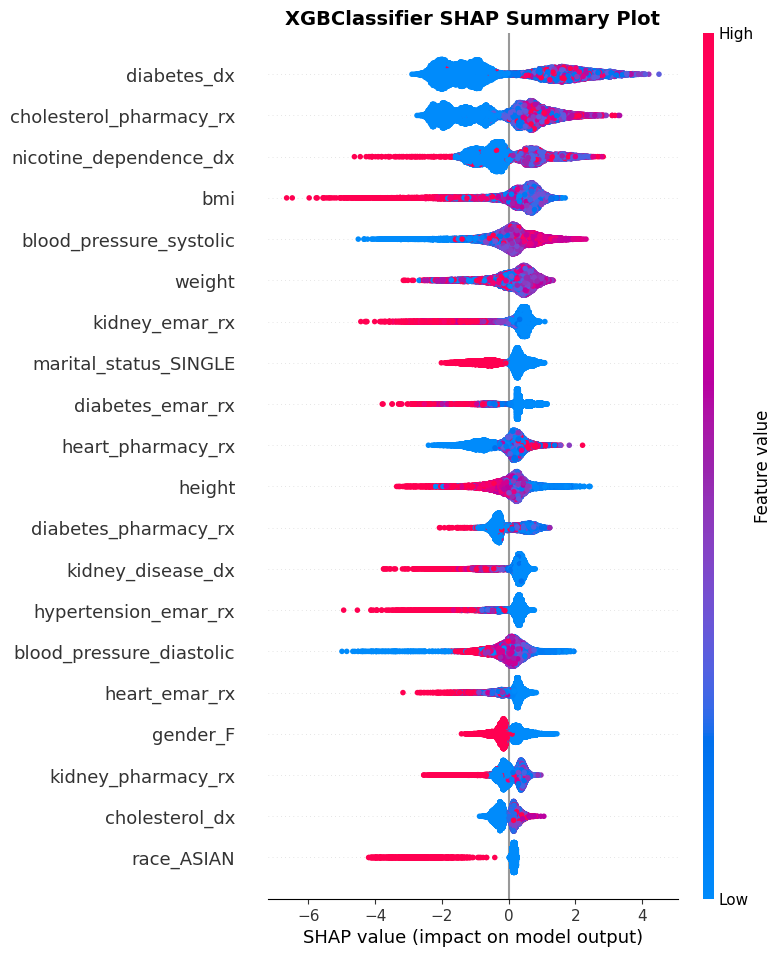


Training RandomForestClassifier...
Iteration 1

RandomForestClassifier Evaluation:
Recall: 1.00
Spy Recall: 1.0000
Precision: 0.09
Specificity: 0.00
Sensitivity: 1.00


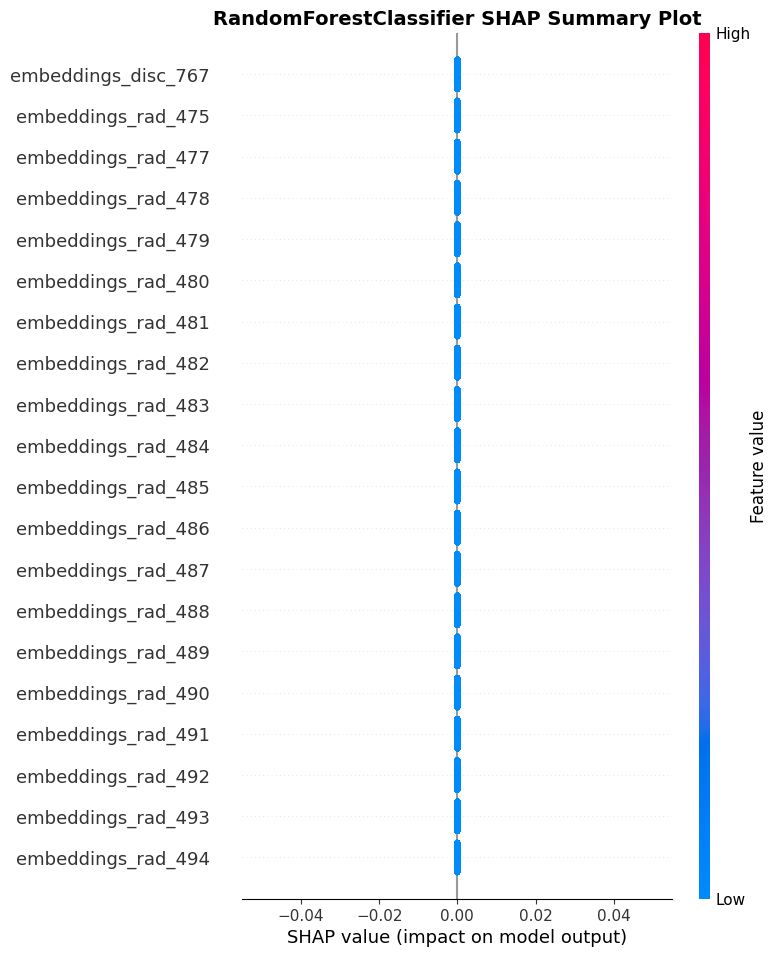


Final Results Across Models:


,Model,Recall,Spy Recall,Precision,Specificity,Sensitivity
0,XGBClassifier,0.98903,0.890173,0.124428,0.307361,0.98903
1,RandomForestClassifier,1.00000,1.000000,0.090515,0.000000,1.00000


In [16]:
# Define Models to Test
models = [
    XGBClassifier(eval_metric="logloss", random_state=SEED, scale_pos_weight =10),
    # SVC(random_state=SEED),
    RandomForestClassifier(n_estimators=100, random_state=SEED),
    # LogisticRegression(max_iter=1000, random_state=SEED),
    # KNeighborsClassifier()
]

# Train PU Models with Fixed Train-Test Split
# experiment_results, y_pred, y_test = pu_learning_experiment_with_split(
#     models, df, target_col, spy_perc=0.1, threshold_for_reliable_neg=10, test_size=0.2, spy_cuttoff=0.5,
# )

experiment_results, y_pred, y_test = pu_learning_experiment(
    models, df, target_col, spy_perc=0.1, threshold_for_reliable_neg=10, iterations=1, spy_cuttoff=0.5,
)

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(experiment_results)
print("\nFinal Results Across Models:")
results_df


Training XGBClassifier...


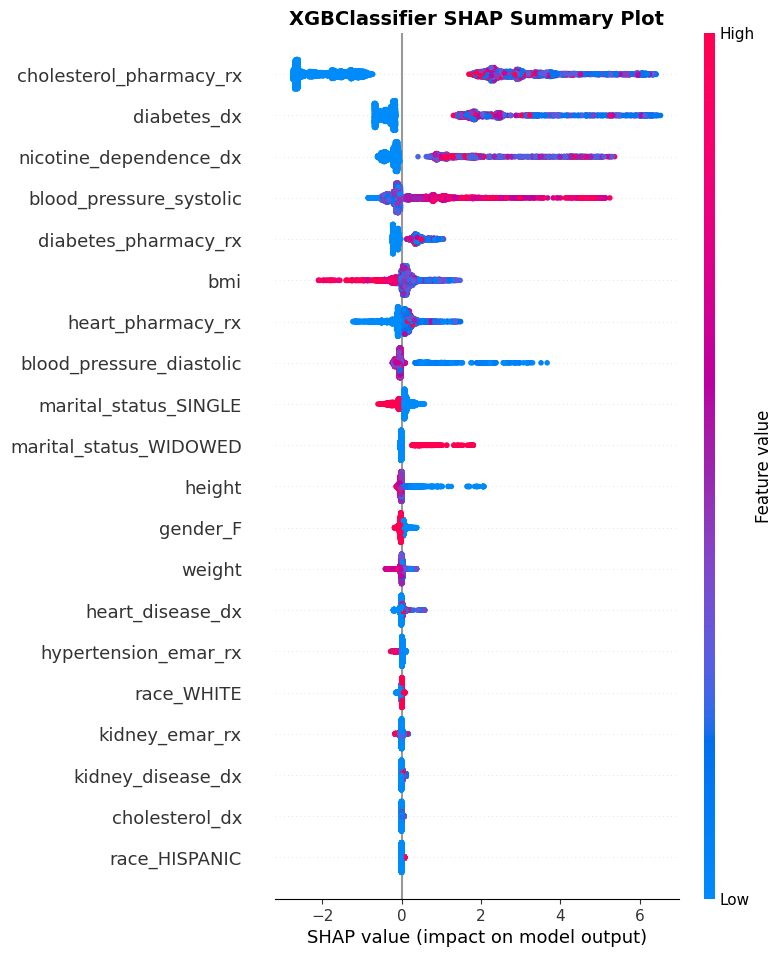


XGBClassifier Evaluation:
Recall: 0.96
Spy Recall: 0.9710
Precision: 0.11
Specificity: 0.26
Sensitivity: 0.96

Final Results Across Models:


,Model,Recall,Spy Recall,Precision,Specificity,Sensitivity
0,XGBClassifier,0.956772,0.971014,0.113504,0.255099,0.956772


In [17]:
# hyper parameter tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'lambda': [0, 1, 10],
    'alpha': [0, 1, 10]
}

models = [
    XGBClassifier(n_estimators=100, learning_rate=0.05, gamma=0.1, alpha=0, eval_metric="logloss", random_state=SEED),
    # XGBClassifier(n_estimators=100, learning_rate=0.05, gamma=0.1, alpha=1, eval_metric="logloss", random_state=SEED),
    # XGBClassifier(n_estimators=100, learning_rate=0.05, gamma=0.1, alpha=10, eval_metric="logloss", random_state=SEED),
]

experiment_results, y_pred, y_test = pu_learning_experiment_with_split(
    models, df, target_col, spy_perc=0.1, threshold_for_reliable_neg=15, test_size=0.2, spy_cuttoff=0.5, shap_result=True
)

# experiment_results, y_pred, y_test = pu_learning_experiment(
#     models, df, target_col, spy_perc=0.1, threshold_for_reliable_neg=15, spy_cuttoff=0.99, shap_result=False
# )

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(experiment_results)
print("\nFinal Results Across Models:")
results_df

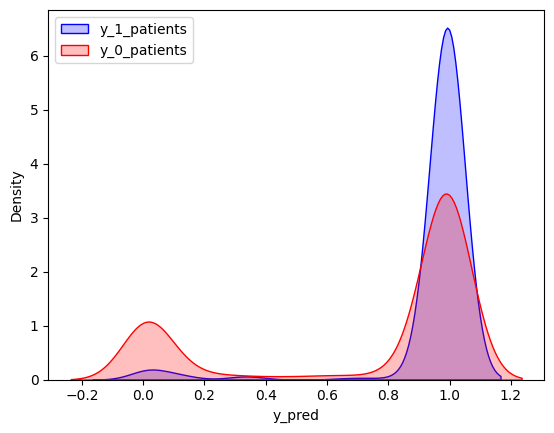

In [18]:
import seaborn as sns

review = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
t_pred = review[review['y_test'] == 1]['y_pred']
f_pred = review[review['y_test'] == 0]['y_pred']

sns.kdeplot(t_pred, color='blue', label='y_1_patients', fill=True)
sns.kdeplot(f_pred, color='red', label='y_0_patients', fill=True)
plt.legend()
plt.show()

In [19]:
df.head()

,gold_flag,blood_pressure_systolic,blood_pressure_diastolic,bmi,height,weight,cardiovascular_px,renal_px,cardiovascular_hcpcs_px,cardiovascular_drg_dx,...,embeddings_disc_758,embeddings_disc_759,embeddings_disc_760,embeddings_disc_761,embeddings_disc_762,embeddings_disc_763,embeddings_disc_764,embeddings_disc_765,embeddings_disc_766,embeddings_disc_767
0,1,-0.409286,-1.475547,-0.012634,-0.42807,-0.591633,2,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-0.57786,-0.359093,0.005011,-0.106695,1.377586,1,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.265009,-2.592001,0.020993,-0.267383,2.772626,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-0.915008,-1.289472,0.00972,-0.070097,-0.207768,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-0.015947,0.571285,-0.012122,0.134231,-0.008949,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Assuming the XGBoost model is the first model in the models list
xgb_model = models[0]

# Prepare the data for prediction
X_all = df.drop(columns=[target_col]).apply(pd.to_numeric, errors='coerce').astype(float)

# Get predictions
y_pred_all = xgb_model.predict(X_all)
y_probs = xgb_model.predict_proba(X_all)[:, 1]


# Create a new dataframe with subject_id and predictions
df_patients['prediction_flag'] = y_pred_all
df_patients['prediction_probability'] = y_probs

# Display the new dataframe with subject_id and prediction flags
df_patients.head()

C:\Users\John\AppData\Local\Temp\ipykernel_7940\2205519103.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patients['prediction_flag'] = y_pred_all
C:\Users\John\AppData\Local\Temp\ipykernel_7940\2205519103.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patients['prediction_probability'] = y_probs


,subject_id,prediction_flag,prediction_probability
0,12289464,1,0.994909
1,11152219,1,0.994909
2,12014559,1,0.994909
3,10390531,1,0.992671
4,14669875,1,0.994145


In [21]:
df_patients['prediction_flag'].value_counts()

prediction_flag
1    14696
0     4439
Name: count, dtype: int64

In [22]:
# Perform a left join of df_target to df_patients on 'subject_id'
df_patients = pd.merge(df_patients, df_target[['subject_id', 'gold_flag']], on='subject_id', how='left')

# Display the updated dataframe
df_patients.head()

,subject_id,prediction_flag,prediction_probability,gold_flag
0,12289464,1,0.994909,1
1,11152219,1,0.994909,1
2,12014559,1,0.994909,1
3,10390531,1,0.992671,1
4,14669875,1,0.994145,1


In [23]:
# Create a summary dataframe
summary = pd.DataFrame(columns=['threshold', 'all_patients', 'gold_patients', 'non_gold_patients'])

# Iterate over thresholds from 1.00 to 0.00 with a step of 0.01
for threshold in np.arange(1.00, -0.01, -0.01):
    gold_patients = df_patients[(df_patients['gold_flag'] == 1) & (df_patients['prediction_probability'] >= threshold)].shape[0]
    non_gold_patients = df_patients[(df_patients['gold_flag'] == 0) & (df_patients['prediction_probability'] >= threshold)].shape[0]
    all_patients = df_patients[(df_patients['prediction_probability'] >= threshold)].shape[0]
    summary.loc[len(summary)] = [threshold, all_patients, gold_patients, non_gold_patients]

summary

,threshold,all_patients,gold_patients,non_gold_patients
0,1.000000e+00,0.0,0.0,0.0
1,9.900000e-01,11703.0,1526.0,10177.0
2,9.800000e-01,12355.0,1590.0,10765.0
3,9.700000e-01,12799.0,1626.0,11173.0
4,9.600000e-01,13018.0,1642.0,11376.0
...,...,...,...,...
96,4.000000e-02,15754.0,1720.0,14034.0
97,3.000000e-02,15912.0,1720.0,14192.0
98,2.000000e-02,16135.0,1724.0,14411.0
99,1.000000e-02,16691.0,1727.0,14964.0


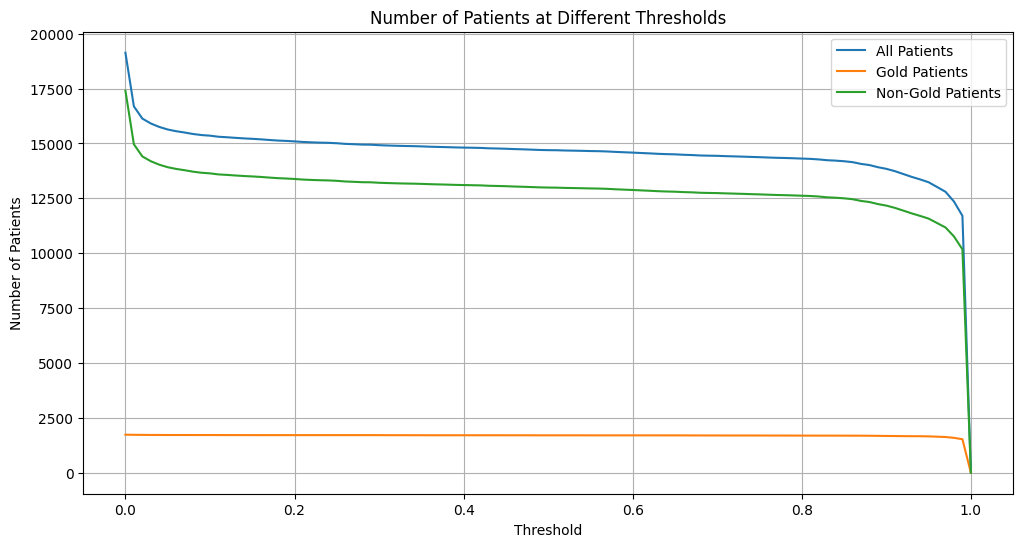

In [24]:
import matplotlib.pyplot as plt

# Plot the summary dataframe
plt.figure(figsize=(12, 6))
plt.plot(summary['threshold'], summary['all_patients'], label='All Patients')
plt.plot(summary['threshold'], summary['gold_patients'], label='Gold Patients')
plt.plot(summary['threshold'], summary['non_gold_patients'], label='Non-Gold Patients')

plt.xlabel('Threshold')
plt.ylabel('Number of Patients')
plt.title('Number of Patients at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

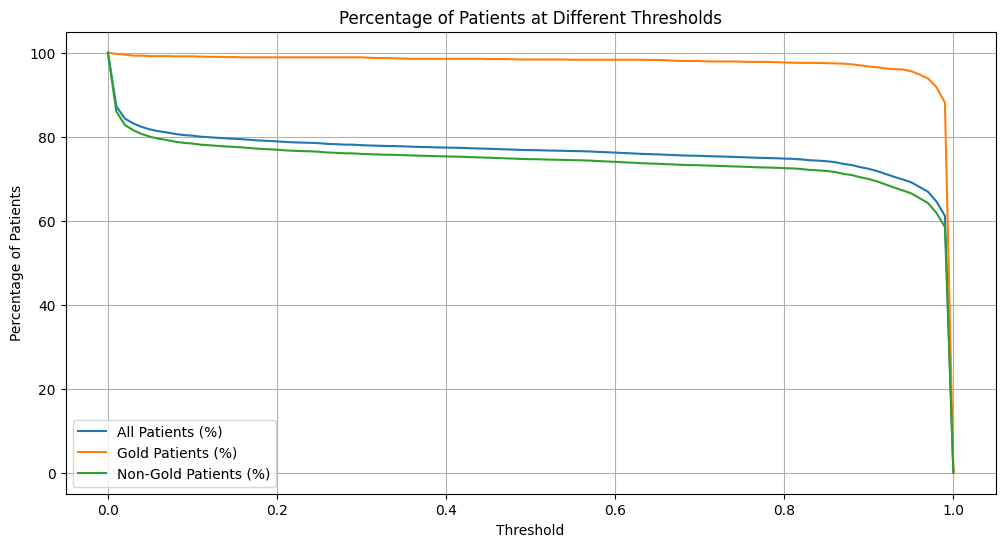

In [25]:
# Calculate percentages
summary['all_patients_perc'] = (summary['all_patients'] / all_patients) * 100
summary['gold_patients_perc'] = (summary['gold_patients'] / gold_patients) * 100
summary['non_gold_patients_perc'] = (summary['non_gold_patients'] / non_gold_patients) * 100

# Plot the summary dataframe as percentages
plt.figure(figsize=(12, 6))
plt.plot(summary['threshold'], summary['all_patients_perc'], label='All Patients (%)')
plt.plot(summary['threshold'], summary['gold_patients_perc'], label='Gold Patients (%)')
plt.plot(summary['threshold'], summary['non_gold_patients_perc'], label='Non-Gold Patients (%)')

plt.xlabel('Threshold')
plt.ylabel('Percentage of Patients')
plt.title('Percentage of Patients at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Create a new column 'patient_type' based on the conditions
df_patients['patient_type'] = df_patients.apply(
    lambda row: 'gold_standard' if row['gold_flag'] == 1 else ('predicted_positive' if row['prediction_flag'] == 1 else 'predicted_negative'),
    axis=1
)

# Create the new dataframe with 'subject_id' and 'patient_type'
df_new = df_patients[['subject_id', 'patient_type']]

# Display the new dataframe
df_new.head()

,subject_id,patient_type
0,12289464,gold_standard
1,11152219,gold_standard
2,12014559,gold_standard
3,10390531,gold_standard
4,14669875,gold_standard


In [ ]:
df_new.to_csv('final_patient_category.csv', index=False)

In [27]:
summary.to_csv('thresholds.csv', index=False)